In [1]:
import matplotlib.pyplot as plt
import numpy as np
import verde as vd
import harmonica as hm
import xrft
import skimage
import xarray as xr

import pyproj
import pygmt

import euler

import warnings

warnings.filterwarnings("ignore")

In [2]:
# The data are in a pandas.DataFrame
data = vd.datasets.fetch_rio_magnetic()
data.head()

longitude   latitude  total_field_anomaly_nt  height_ell_m line_type  \
0 -42.590424 -22.499878                  115.41        264.26      LINE   
1 -42.590485 -22.498978                  121.35        265.48      LINE   
2 -42.590530 -22.498077                  128.29        263.96      LINE   
3 -42.590591 -22.497177                  133.24        258.47      LINE   
4 -42.590652 -22.496277                  136.18        252.07      LINE   

   line_number  
0         2902  
1         2902  
2         2902  
3         2902  
4         2902

### Project coordinates

In [3]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
easting, northing = projection(data.longitude.values, data.latitude.values)
coordinates = (easting, northing, data.height_ell_m)

data = data.assign(easting_m=easting)
data = data.assign(northing_m=northing)
data

longitude   latitude  total_field_anomaly_nt  height_ell_m line_type  \
0     -42.590424 -22.499878                  115.41        264.26      LINE   
1     -42.590485 -22.498978                  121.35        265.48      LINE   
2     -42.590530 -22.498077                  128.29        263.96      LINE   
3     -42.590591 -22.497177                  133.24        258.47      LINE   
4     -42.590652 -22.496277                  136.18        252.07      LINE   
...          ...        ...                     ...           ...       ...   
37713 -42.023544 -22.073761                    6.20        269.75       TIE   
37714 -42.024536 -22.073776                   16.26        263.96       TIE   
37715 -42.025513 -22.073776                   30.33        255.73       TIE   
37716 -42.026505 -22.073776                   46.39        247.19       TIE   
37717 -42.027496 -22.073776                   61.45        240.49       TIE   

       line_number     easting_m    northing_m  
0             2902 -4.390282e+06 -2.366202e+06  
1             2902 -4.390289e+06 -2.366102e+06  
2             2902 -4.390293e+06 -2.366002e+06  
3             2902 -4.390300e+06 -2.365902e+06  
4             2902 -4.390306e+06 -2.365802e+06  
...            ...           ...           ...  
37713         9600 -4.331848e+06 -2.319003e+06  
37714         9600 -4.331950e+06 -2.319005e+06  
37715         9600 -4.332051e+06 -2.319005e+06  
37716         9600 -4.332153e+06 -2.319005e+06  
37717         9600 -4.332255e+06 -2.319005e+06  

[37718 rows x 8 columns]

In [4]:
region_degrees = [
    data.longitude.min(),
    data.longitude.max(),
    data.latitude.min(),
    data.latitude.max(),
]
region_meters = [
    data.easting_m.min(),
    data.easting_m.max(),
    data.northing_m.min(),
    data.northing_m.max(),
]

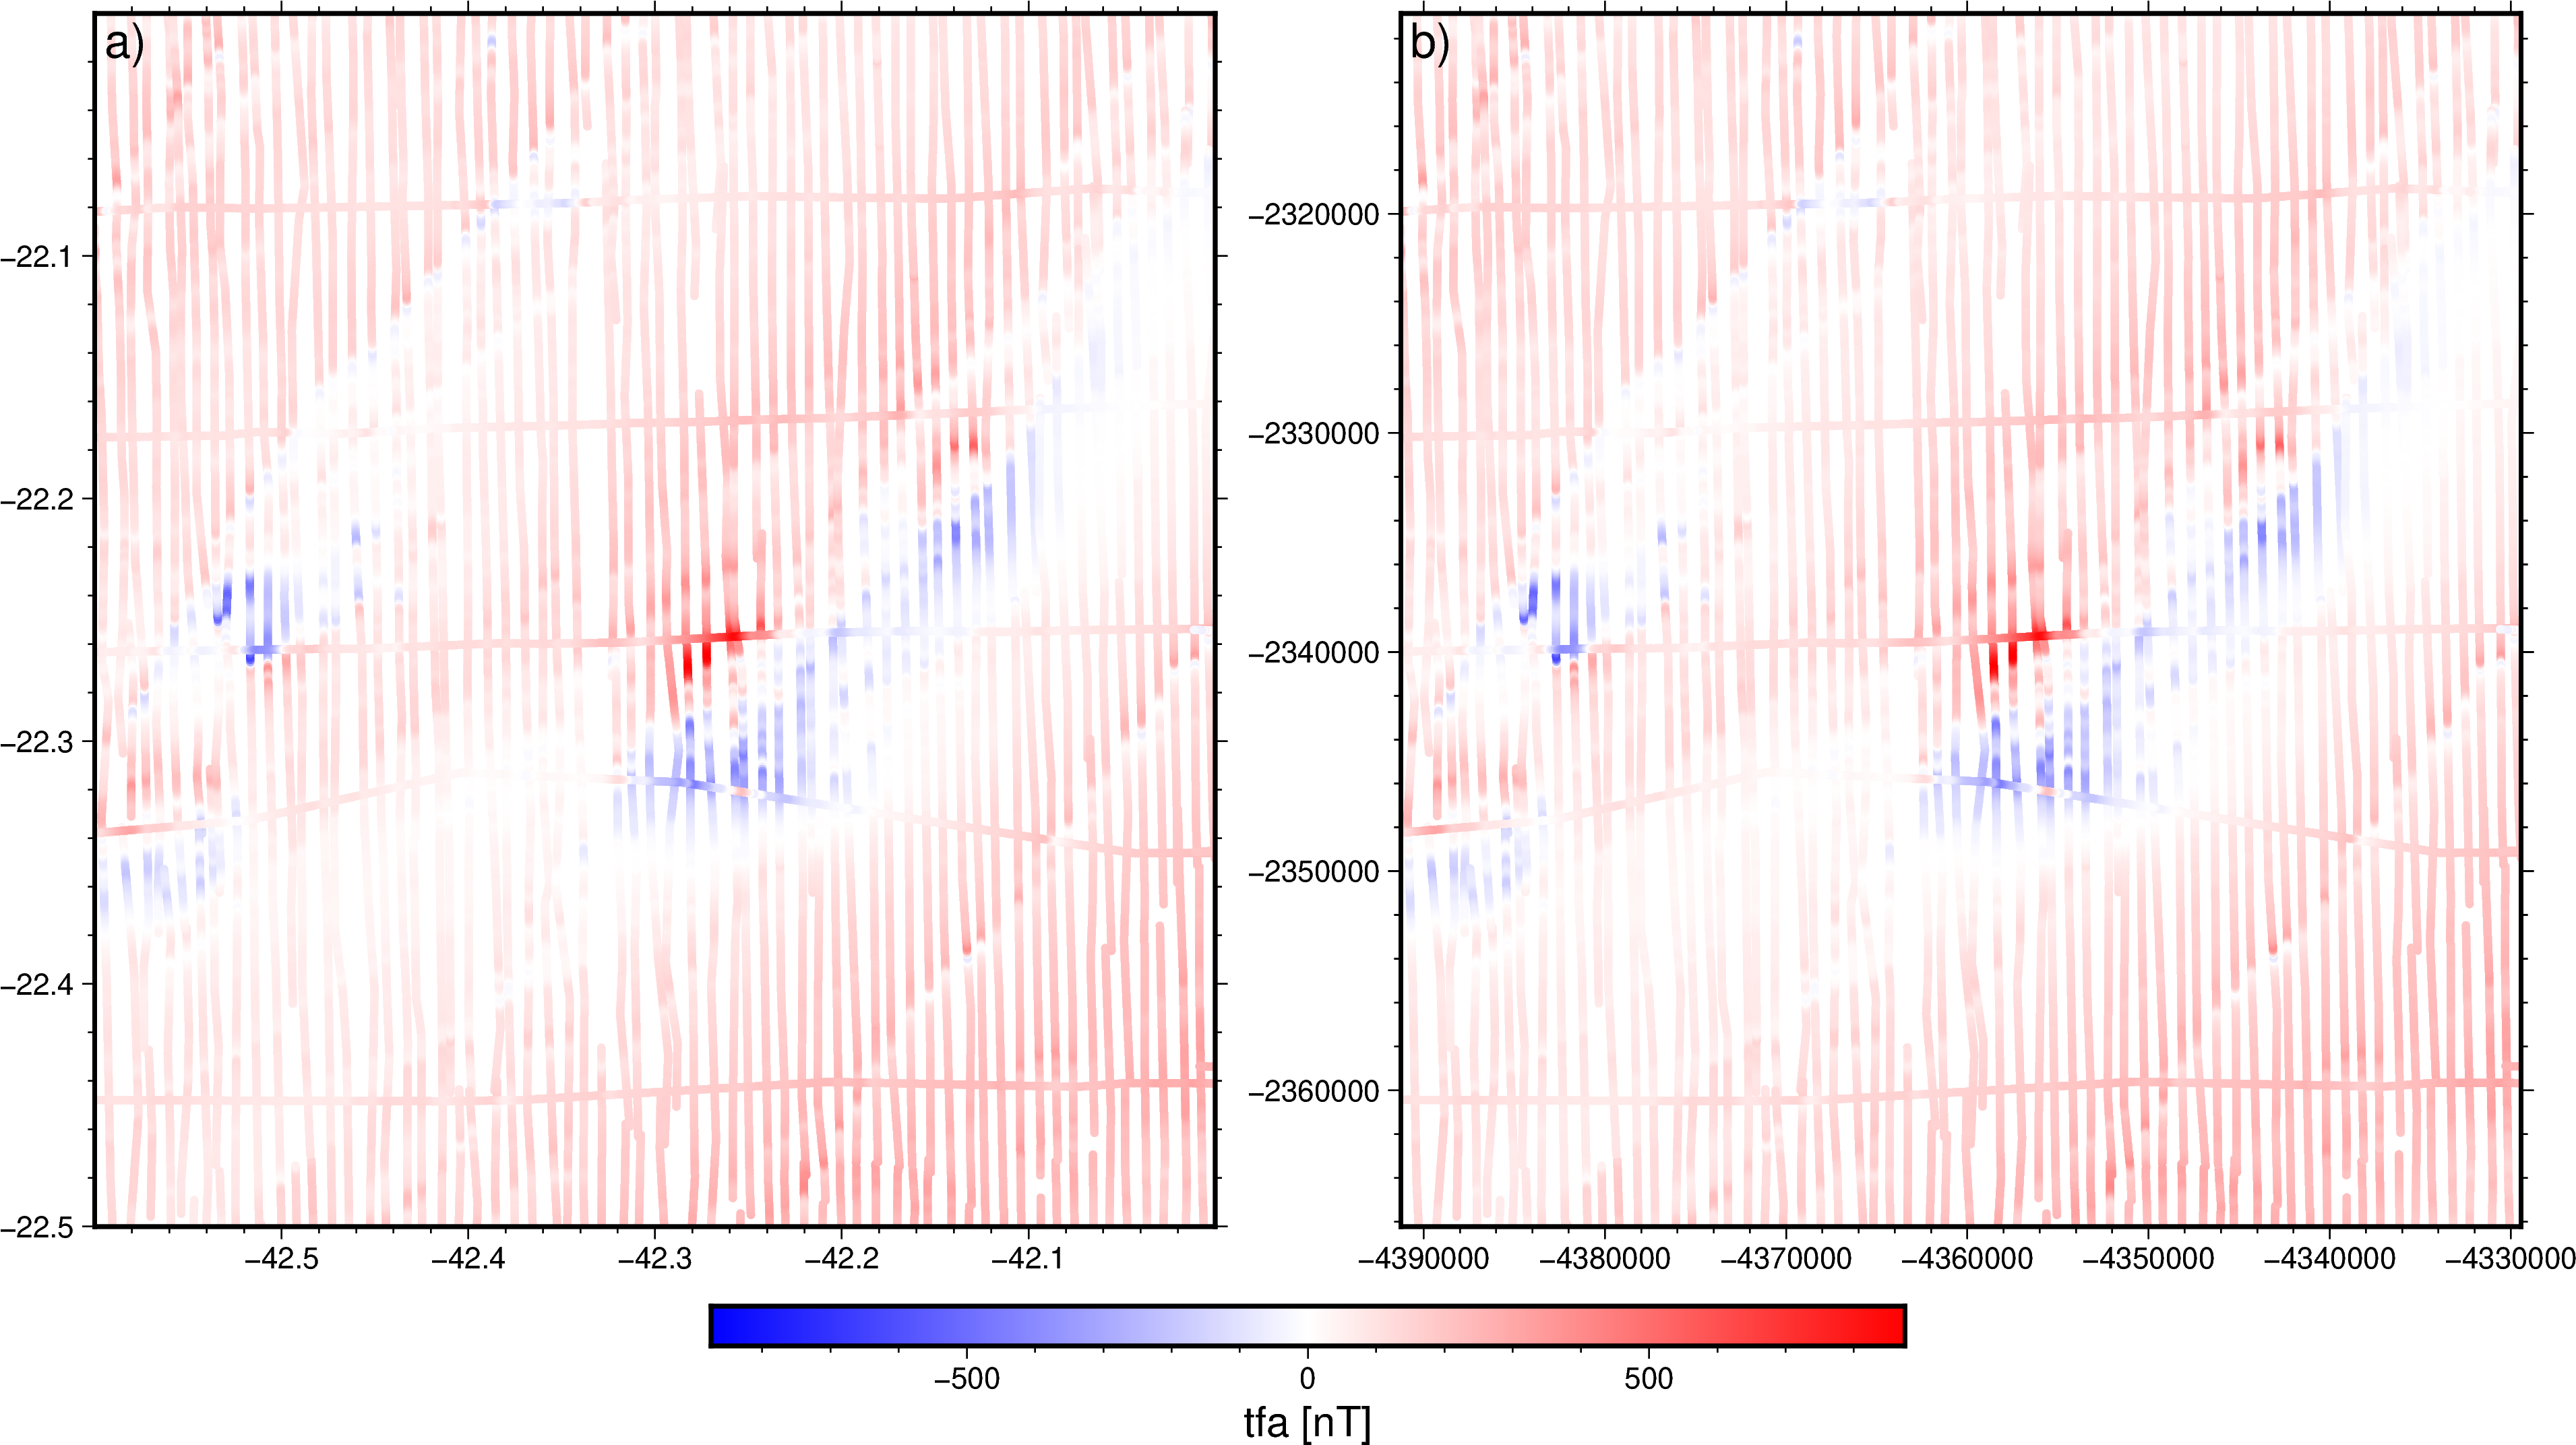

In [5]:
fig = pygmt.Figure()
maxabs = vd.maxabs(data.total_field_anomaly_nt)
pygmt.makecpt(cmap="polar+h", series=[-maxabs, maxabs])
with fig.subplot(
    nrows=1, ncols=2, figsize=("12i", "6i"), autolabel=True, margins="0.9c"
):
    with fig.set_panel(panel=0):
        pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
        fig.plot(
            x=data.longitude,
            y=data.latitude,
            fill=data.total_field_anomaly_nt,
            cmap=True,
            style="c0.1c",
            frame=["WSne", "xaf", "yaf"],
            region=region_degrees,
        )

    with fig.set_panel(panel=1):
        pygmt.makecpt(cmap="polar", series=[-maxabs, maxabs])
        fig.plot(
            x=data.easting_m,
            y=data.northing_m,
            fill=data.total_field_anomaly_nt,
            cmap=True,
            style="c0.1c",
            frame=["WSne", "xaf", "yaf"],
            region=region_meters,
        )
fig.colorbar(
    position="JBC+o0c/1c+w15c/0.5c", frame="af+ltfa [nT]"  # Adjust position and size
)
fig.show()

In [6]:
grid_spacing = 0.1e3

eqs = hm.EquivalentSourcesGB(
    depth=2.0e3, damping=10, block_size=grid_spacing, window_size=10e3, random_state=42
)

In [7]:
eqs.estimate_required_memory(coordinates)

np.int64(12503952)

In [8]:
eqs.fit(coordinates, data.total_field_anomaly_nt)

EquivalentSourcesGB(block_size=100.0, damping=10, depth=2000.0, random_state=42,
                    window_size=10000.0)

In [9]:
region = vd.get_region(coordinates)
grid_coords = vd.grid_coordinates(
    region=region,
    spacing=grid_spacing,
    extra_coords=data.height_ell_m.max(),
)
grid = eqs.grid(grid_coords, data_names=["tfa_nt"])
grid

<xarray.Dataset> Size: 6MB
Dimensions:   (northing: 555, easting: 619)
Coordinates:
  * easting   (easting) float64 5kB -4.391e+06 -4.391e+06 ... -4.329e+06
  * northing  (northing) float64 4kB -2.366e+06 -2.366e+06 ... -2.311e+06
    upward    (northing, easting) float64 3MB 300.0 300.0 300.0 ... 300.0 300.0
Data variables:
    tfa_nt    (northing, easting) float64 3MB 113.0 114.0 114.9 ... 170.7 173.6
Attributes:
    metadata:  Generated by EquivalentSourcesGB(block_size=100.0, damping=10,...

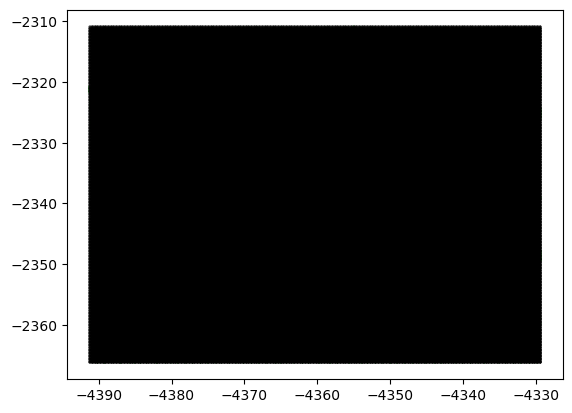

In [10]:
grid_table = vd.grid_to_table(grid)

plt.scatter(data.easting_m / 1.0e3, data.northing_m / 1.0e3, color="g", s=0.1)
plt.scatter(grid_table.easting / 1.0e3, grid_table.northing / 1.0e3, color="k", s=0.1)

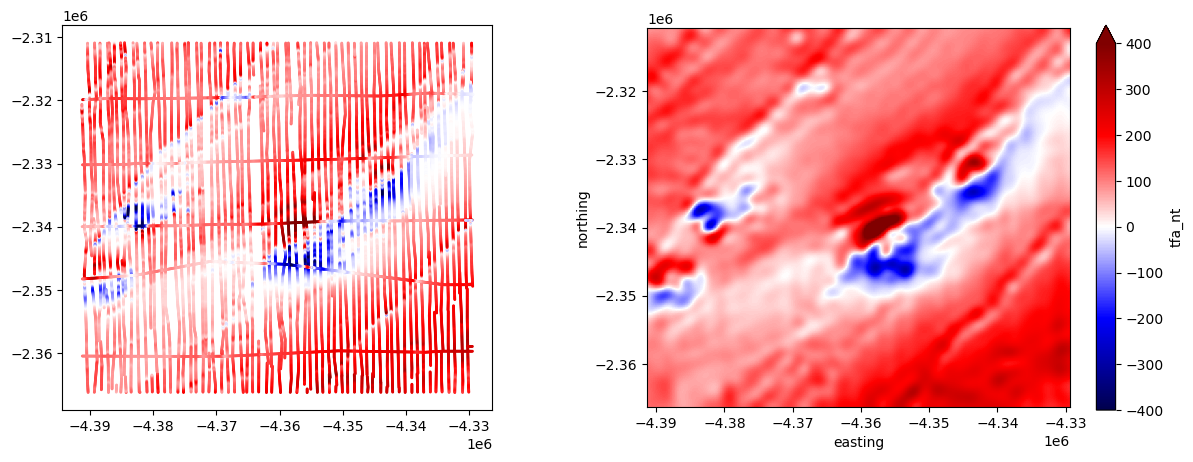

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.ravel()

ax = axes[0]
# maxabs = vd.maxabs(data.total_field_anomaly_nt)
ax.scatter(
    data.easting_m,
    data.northing_m,
    c=data.total_field_anomaly_nt,
    s=1,
    cmap="seismic",
    vmin=-400,
    vmax=400,
    # transform=crs,
)
ax.set_aspect("equal")

ax = axes[1]
tmp = grid.tfa_nt.plot.pcolormesh(cmap="seismic", vmax=400, vmin=-400)
ax.set_aspect("equal")

# Calculate the residual

In [12]:
# grid_check_table = vd.grid_to_table(grid_check)
# interpolator = vd.KNeighbors()
# interpolator.fit((grid_check_table.easting, grid_check_table.northing), grid_check_table.tfa_nt)
# data = data.assign(eqs_grid_tfa_nt=interpolator.predict((data.easting_m, data.northing_m)))
# data = data.assign(residual=data.total_field_anomaly_nt - data.eqs_grid_tfa_nt)
# data

In [13]:
tfa_predict = eqs.predict(coordinates)
data = data.assign(tfa_predict=tfa_predict)
data = data.assign(residual=data.total_field_anomaly_nt - tfa_predict)
data

longitude   latitude  total_field_anomaly_nt  height_ell_m line_type  \
0     -42.590424 -22.499878                  115.41        264.26      LINE   
1     -42.590485 -22.498978                  121.35        265.48      LINE   
2     -42.590530 -22.498077                  128.29        263.96      LINE   
3     -42.590591 -22.497177                  133.24        258.47      LINE   
4     -42.590652 -22.496277                  136.18        252.07      LINE   
...          ...        ...                     ...           ...       ...   
37713 -42.023544 -22.073761                    6.20        269.75       TIE   
37714 -42.024536 -22.073776                   16.26        263.96       TIE   
37715 -42.025513 -22.073776                   30.33        255.73       TIE   
37716 -42.026505 -22.073776                   46.39        247.19       TIE   
37717 -42.027496 -22.073776                   61.45        240.49       TIE   

       line_number     easting_m    northing_m  tfa_predict   residual  
0             2902 -4.390282e+06 -2.366202e+06   119.600556  -4.190556  
1             2902 -4.390289e+06 -2.366102e+06   120.622970   0.727030  
2             2902 -4.390293e+06 -2.366002e+06   121.631920   6.658080  
3             2902 -4.390300e+06 -2.365902e+06   122.645590  10.594410  
4             2902 -4.390306e+06 -2.365802e+06   123.593479  12.586521  
...            ...           ...           ...          ...        ...  
37713         9600 -4.331848e+06 -2.319003e+06    16.051288  -9.851288  
37714         9600 -4.331950e+06 -2.319005e+06    19.074118  -2.814118  
37715         9600 -4.332051e+06 -2.319005e+06    21.878361   8.451639  
37716         9600 -4.332153e+06 -2.319005e+06    24.482402  21.907598  
37717         9600 -4.332255e+06 -2.319005e+06    26.801160  34.648840  

[37718 rows x 10 columns]

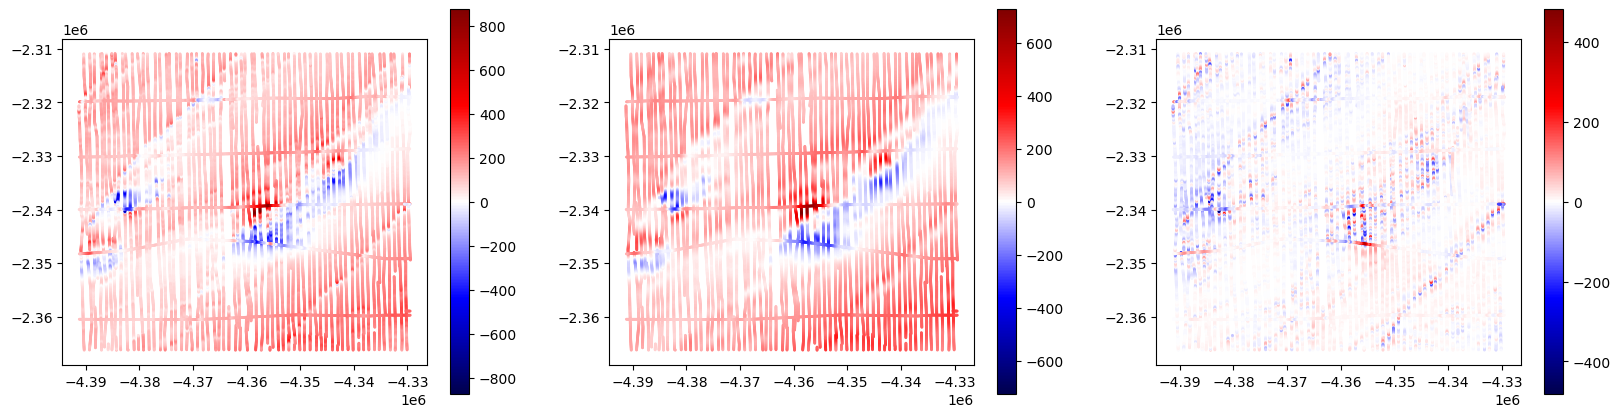

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)
scale = 400
# data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
axes = axes.ravel()

ax = axes[0]
tmp1 = ax.scatter(
    data.easting_m,
    data.northing_m,
    c=data.total_field_anomaly_nt,
    s=1,
    cmap="seismic",
    vmin=-vd.maxabs(data.total_field_anomaly_nt),
    vmax=vd.maxabs(data.total_field_anomaly_nt),
)
plt.colorbar(tmp1, ax=ax)
ax.set_aspect("equal")

ax = axes[1]
tmp2 = ax.scatter(
    data.easting_m,
    data.northing_m,
    c=data.tfa_predict,
    s=1,
    cmap="seismic",
    vmin=-vd.maxabs(data.tfa_predict),
    vmax=vd.maxabs(data.tfa_predict),
)
plt.colorbar(tmp2, ax=ax)
ax.set_aspect("equal")

ax = axes[2]
tmp3 = ax.scatter(
    data.easting_m,
    data.northing_m,
    c=data.residual,
    s=1,
    cmap="seismic",
    vmin=-vd.maxabs(data.residual),
    vmax=vd.maxabs(data.residual),
)
plt.colorbar(tmp3, ax=ax)
ax.set_aspect("equal")

fig.show()

# fig.colorbar(tmp, **cbar_kwargs, label="tfa [nT]", cax=fig.add_axes([0.25, 0.05, 0.5, 0.01]))

# Calculate the derivatives

In [15]:
delta_h = 10
deast = (
    eqs.predict((coordinates[0] + delta_h, coordinates[1], coordinates[2]))
    - eqs.predict((coordinates[0] - delta_h, coordinates[1], coordinates[2]))
) / (2 * delta_h)


dnorth = (
    eqs.predict((coordinates[0], coordinates[1] + delta_h, coordinates[2]))
    - eqs.predict((coordinates[0], coordinates[1] - delta_h, coordinates[2]))
) / (2 * delta_h)


delta_v = 5
dup = (
    eqs.predict((coordinates[0], coordinates[1], coordinates[2] + delta_v))
    - eqs.predict((coordinates[0], coordinates[1], coordinates[2] - delta_v))
) / (2 * delta_v)

In [16]:
data = data.assign(easting_derivative=deast)
data = data.assign(northing_derivative=dnorth)
data = data.assign(upward_derivative=dup)
data

longitude   latitude  total_field_anomaly_nt  height_ell_m line_type  \
0     -42.590424 -22.499878                  115.41        264.26      LINE   
1     -42.590485 -22.498978                  121.35        265.48      LINE   
2     -42.590530 -22.498077                  128.29        263.96      LINE   
3     -42.590591 -22.497177                  133.24        258.47      LINE   
4     -42.590652 -22.496277                  136.18        252.07      LINE   
...          ...        ...                     ...           ...       ...   
37713 -42.023544 -22.073761                    6.20        269.75       TIE   
37714 -42.024536 -22.073776                   16.26        263.96       TIE   
37715 -42.025513 -22.073776                   30.33        255.73       TIE   
37716 -42.026505 -22.073776                   46.39        247.19       TIE   
37717 -42.027496 -22.073776                   61.45        240.49       TIE   

       line_number     easting_m    northing_m  tfa_predict   residual  \
0             2902 -4.390282e+06 -2.366202e+06   119.600556  -4.190556   
1             2902 -4.390289e+06 -2.366102e+06   120.622970   0.727030   
2             2902 -4.390293e+06 -2.366002e+06   121.631920   6.658080   
3             2902 -4.390300e+06 -2.365902e+06   122.645590  10.594410   
4             2902 -4.390306e+06 -2.365802e+06   123.593479  12.586521   
...            ...           ...           ...          ...        ...   
37713         9600 -4.331848e+06 -2.319003e+06    16.051288  -9.851288   
37714         9600 -4.331950e+06 -2.319005e+06    19.074118  -2.814118   
37715         9600 -4.332051e+06 -2.319005e+06    21.878361   8.451639   
37716         9600 -4.332153e+06 -2.319005e+06    24.482402  21.907598   
37717         9600 -4.332255e+06 -2.319005e+06    26.801160  34.648840   

       easting_derivative  northing_derivative  upward_derivative  
0                0.000995             0.010938          -0.021479  
1                0.001404             0.010212          -0.022145  
2                0.001836             0.009432          -0.022726  
3                0.002319             0.008595          -0.023244  
4                0.002849             0.007704          -0.023627  
...                   ...                  ...                ...  
37713           -0.031788             0.033293           0.015104  
37714           -0.029707             0.030139           0.010283  
37715           -0.027230             0.026843           0.006005  
37716           -0.024333             0.023353           0.002333  
37717           -0.021156             0.019871          -0.000459  

[37718 rows x 13 columns]

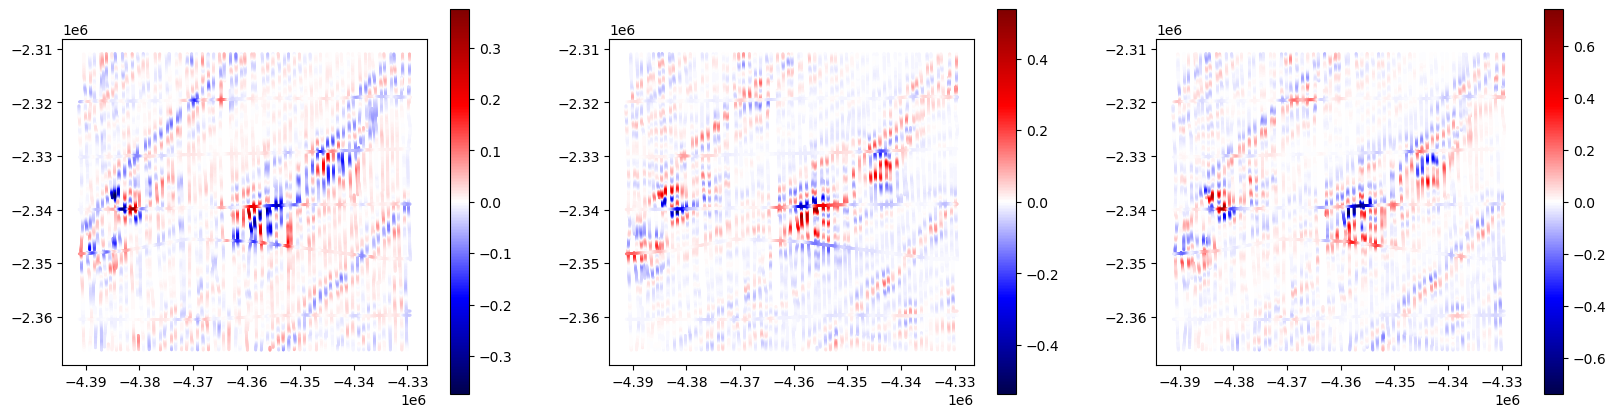

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)
scale = 400
# data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
axes = axes.ravel()

ax = axes[0]
tmp1 = ax.scatter(
    data.easting_m,
    data.northing_m,
    c=data.easting_derivative,
    s=1,
    cmap="seismic",
    vmin=-vd.maxabs(data.easting_derivative),
    vmax=vd.maxabs(data.easting_derivative),
)
plt.colorbar(tmp1, ax=ax)
ax.set_aspect("equal")

ax = axes[1]
tmp2 = ax.scatter(
    data.easting_m,
    data.northing_m,
    c=data.northing_derivative,
    s=1,
    cmap="seismic",
    vmin=-vd.maxabs(data.northing_derivative),
    vmax=vd.maxabs(data.northing_derivative),
)
plt.colorbar(tmp2, ax=ax)
ax.set_aspect("equal")

ax = axes[2]
tmp3 = ax.scatter(
    data.easting_m,
    data.northing_m,
    c=data.upward_derivative,
    s=1,
    cmap="seismic",
    vmin=-vd.maxabs(data.upward_derivative),
    vmax=vd.maxabs(data.upward_derivative),
)
plt.colorbar(tmp3, ax=ax)
ax.set_aspect("equal")

fig.show()

# fig.colorbar(tmp, **cbar_kwargs, label="tfa [nT]", cax=fig.add_axes([0.25, 0.05, 0.5, 0.01]))

# Derivatives using grid

In [18]:
grid["deriv_east"] = hm.derivative_easting(grid.tfa_nt)
grid["deriv_north"] = hm.derivative_northing(grid.tfa_nt)


magnetic_grid_no_height = grid.drop_vars("upward")


pad_width = {
    "easting": grid.easting.size // 3,
    "northing": grid.northing.size // 3,
}


padded = xrft.pad(
    magnetic_grid_no_height.tfa_nt, pad_width, mode="linear_ramp", constant_values=None
)
grid["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)


grid = grid.assign(
    tga=np.sqrt(grid.deriv_east**2 + grid.deriv_north**2 + grid.deriv_up**2)
)

grid

<xarray.Dataset> Size: 16MB
Dimensions:      (northing: 555, easting: 619)
Coordinates:
  * easting      (easting) float64 5kB -4.391e+06 -4.391e+06 ... -4.329e+06
  * northing     (northing) float64 4kB -2.366e+06 -2.366e+06 ... -2.311e+06
    upward       (northing, easting) float64 3MB 300.0 300.0 ... 300.0 300.0
Data variables:
    tfa_nt       (northing, easting) float64 3MB 113.0 114.0 ... 170.7 173.6
    deriv_east   (northing, easting) float64 3MB 0.009309 0.009012 ... 0.02951
    deriv_north  (northing, easting) float64 3MB 0.007197 0.007516 ... 0.008015
    deriv_up     (northing, easting) float64 3MB -0.00721 -0.01115 ... -0.1314
    tga          (northing, easting) float64 3MB 0.0138 0.01618 ... 0.1349
Attributes:
    metadata:  Generated by EquivalentSourcesGB(block_size=100.0, damping=10,...

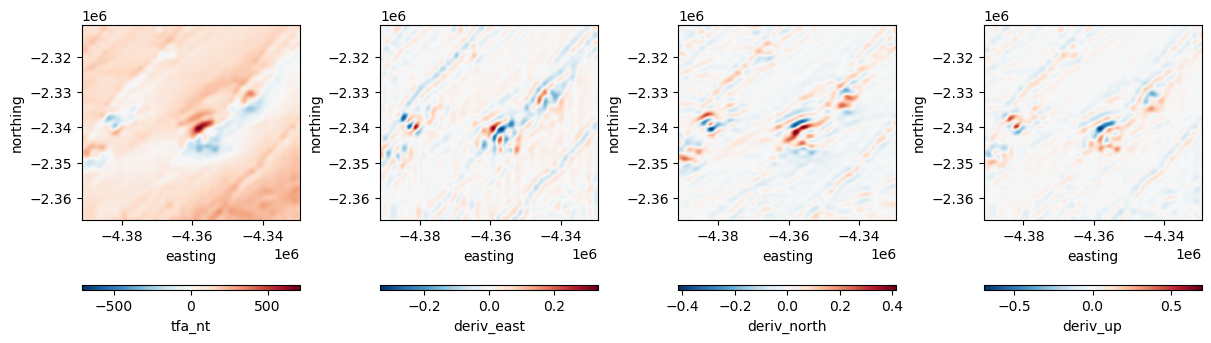

In [19]:
fig, axes = plt.subplots(1, 4, figsize=(12, 5), layout="constrained")
for field, ax in zip(["tfa_nt", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
    grid[field].plot.pcolormesh(
        ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50)
    )
    ax.set_aspect("equal")
plt.show()

# Blob detection

In [20]:
stretched = skimage.exposure.rescale_intensity(
    grid.tga, 
    in_range=tuple(np.percentile(grid.tga, (0.5, 99.5))),
)
grid = grid.assign(tga_stretched=xr.DataArray(stretched, coords=grid.coords))
grid

<xarray.Dataset> Size: 19MB
Dimensions:        (northing: 555, easting: 619)
Coordinates:
  * easting        (easting) float64 5kB -4.391e+06 -4.391e+06 ... -4.329e+06
  * northing       (northing) float64 4kB -2.366e+06 -2.366e+06 ... -2.311e+06
    upward         (northing, easting) float64 3MB 300.0 300.0 ... 300.0 300.0
Data variables:
    tfa_nt         (northing, easting) float64 3MB 113.0 114.0 ... 170.7 173.6
    deriv_east     (northing, easting) float64 3MB 0.009309 0.009012 ... 0.02951
    deriv_north    (northing, easting) float64 3MB 0.007197 ... 0.008015
    deriv_up       (northing, easting) float64 3MB -0.00721 -0.01115 ... -0.1314
    tga            (northing, easting) float64 3MB 0.0138 0.01618 ... 0.1349
    tga_stretched  (northing, easting) float64 3MB 0.02638 0.03284 ... 0.3547
Attributes:
    metadata:  Generated by EquivalentSourcesGB(block_size=100.0, damping=10,...

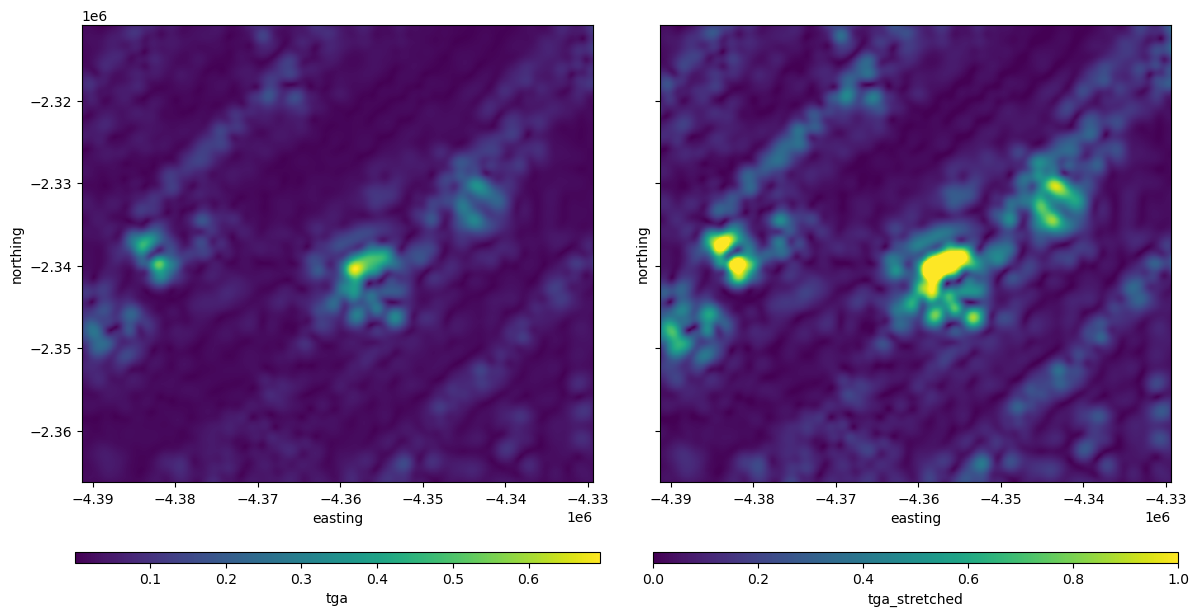

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), layout="constrained", sharey=True)
for field, ax in zip(["tga", "tga_stretched"], axes.ravel()):
    grid[field].plot.pcolormesh(
        ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50)
    )
    ax.set_aspect("equal")
plt.show()

## Windows selection using blob detecion

In [22]:
def detect_anomalies(
    data, size_range, size_increment=2, nsizes=10, threshold=0.5, overlap=0.5, exclude_border=0
):
    """
    Run the blob detection and produce bounding boxes in data coordinates
    """
    min_sigma, max_sigma = [0.5 * i for i in size_range]
    spacing = np.mean([np.abs(data.easting[1] - data.easting[0]), np.abs(data.northing[1] - data.northing[0])])
    iy, ix, sigma_pix = skimage.feature.blob_log(
        data,
        min_sigma=min_sigma / spacing,
        max_sigma=max_sigma / spacing,
        threshold=threshold,
        num_sigma=nsizes,
        overlap=overlap,
        exclude_border= int(exclude_border / spacing),
    ).T
    blob_coords = (data.easting.values[ix.astype("int")], data.northing.values[iy.astype("int")])
    blob_sizes = sigma_pix * np.sqrt(2) * spacing * size_increment
    windows = [
        [x - size, x + size, y - size, y + size]
        for size, x, y in zip(blob_sizes, *blob_coords)
    ]
    return windows

In [50]:
windows = detect_anomalies(
    grid.tga_stretched, 
    size_range=[1.0e3, 15e3],
    size_increment=1.0,
    threshold=0.02,
    overlap=1.0,
    nsizes=10,
    exclude_border=500
)

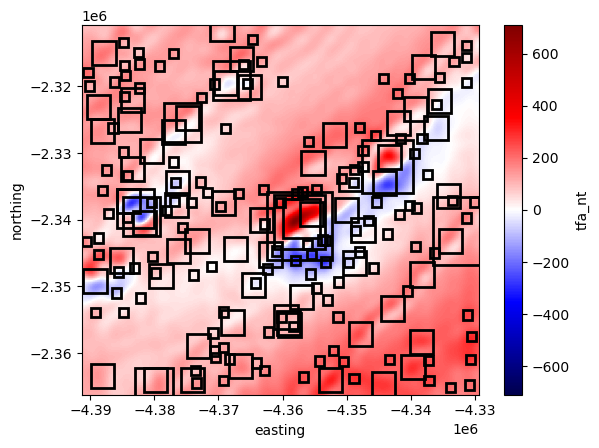

In [51]:
import matplotlib.patches
ax = plt.subplot(111)
grid.tfa_nt.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect) 

# Euler Deconvolution

In [25]:
%%time
# Inicialize o dicionário de deconvoluções
deconvolutions = {1: [], 2: [], 3: []}

# Exemplo de dados gerados para cada chave
for window in windows:
    # Slicing os dados da janela
    data_slice = grid.sel(easting=slice(*window[:2]), northing=slice(*window[2:]))
    for si in deconvolutions.keys():
        # Cria uma nova instância de EulerDeconvolution e ajusta os dados
        deconvolution_result = euler.EulerDeconvolution(
               structural_index=si).fit_grid(data_slice, 
                                             data_names=(['tfa_nt', 'deriv_east', 'deriv_north', 'deriv_up']),
                                            coordinate_names=(['easting', 'northing', 'upward']))
        # Armazena o resultado na lista correspondente
        deconvolutions[si].append(deconvolution_result)

CPU times: user 251 ms, sys: 87 μs, total: 251 ms
Wall time: 250 ms


# Euler Inversion

In [26]:
# %%time
# ei = {1: [], 2: [], 3: []}
# for window in windows:
#     #slice the window data
#     data_slice = grid.sel(easting=slice(*window[:2]), northing=slice(*window[2:]))
#     # choose the best si
#     tolerance = np.inf
#     for si in deconvolutions.keys():
#         ei_result =  euler.EulerInversion(si).fit_grid(data_slice, data_names=(['tfa_nt', 'deriv_east', 'deriv_north', 'deriv_up']),
#                                             coordinate_names=(['easting', 'northing', 'upward']))

#         RMS = ei_result.data_misfit_[-1]

#         if RMS <= tolerance:
#             chosen_si = si   # updates the chosen si
#             tolerance = RMS   # updates the r2 for a bigger one
    
#     ei[chosen_si].append(euler.EulerInversion(chosen_si).fit_grid(data_slice, data_names=(['tfa_nt', 'deriv_east', 'deriv_north', 'deriv_up']),
#                                             coordinate_names=(['easting', 'northing', 'upward'])))

In [27]:
%%time
ei = {1: [], 2: [], 3: []}
for window in windows:
    #slice the window data
    data_slice = grid.sel(easting=slice(*window[:2]), northing=slice(*window[2:]))
    # choose the best si
    tolerance = -np.inf
    for si in deconvolutions.keys():
        ei_result =  euler.EulerInversion(si).fit_grid(data_slice, 
                                                       data_names=(['tfa_nt', 'deriv_east', 'deriv_north', 'deriv_up']),
                                            coordinate_names=(['easting', 'northing', 'upward']))

        weights = np.array([1,0.1,0.1,0.05])
        variables = ['tfa_nt', 'deriv_east', 'deriv_north', 'deriv_up']
        pred_variables = (ei_result.predicted_field_.ravel(), ei_result.predicted_deriv_east_.ravel(),
                          ei_result.predicted_deriv_north_.ravel(), ei_result.predicted_deriv_up_.ravel())
        r2=0
        for weight, variable, d_predicted in zip(weights, variables, pred_variables):
            d = data_slice[variable].values.ravel()
            residuals = d - d_predicted
            residuals_sum_sq = np.sum(residuals**2)
            
            r2 += (1 - residuals_sum_sq / np.linalg.norm(d - d.mean()) ** 2) * weight

        r2 /= weights.sum()
        if r2 >= tolerance:
            chosen_si = si   # updates the chosen si
            tolerance = r2   # updates the r2 for a bigger one
    
    ei[chosen_si].append(euler.EulerInversion(chosen_si).fit_grid(data_slice, 
                         data_names=(['tfa_nt', 'deriv_east', 'deriv_north', 'deriv_up']),
                        coordinate_names=(['easting', 'northing', 'upward'])))

        

CPU times: user 18.7 s, sys: 9.82 ms, total: 18.7 s
Wall time: 4.93 s


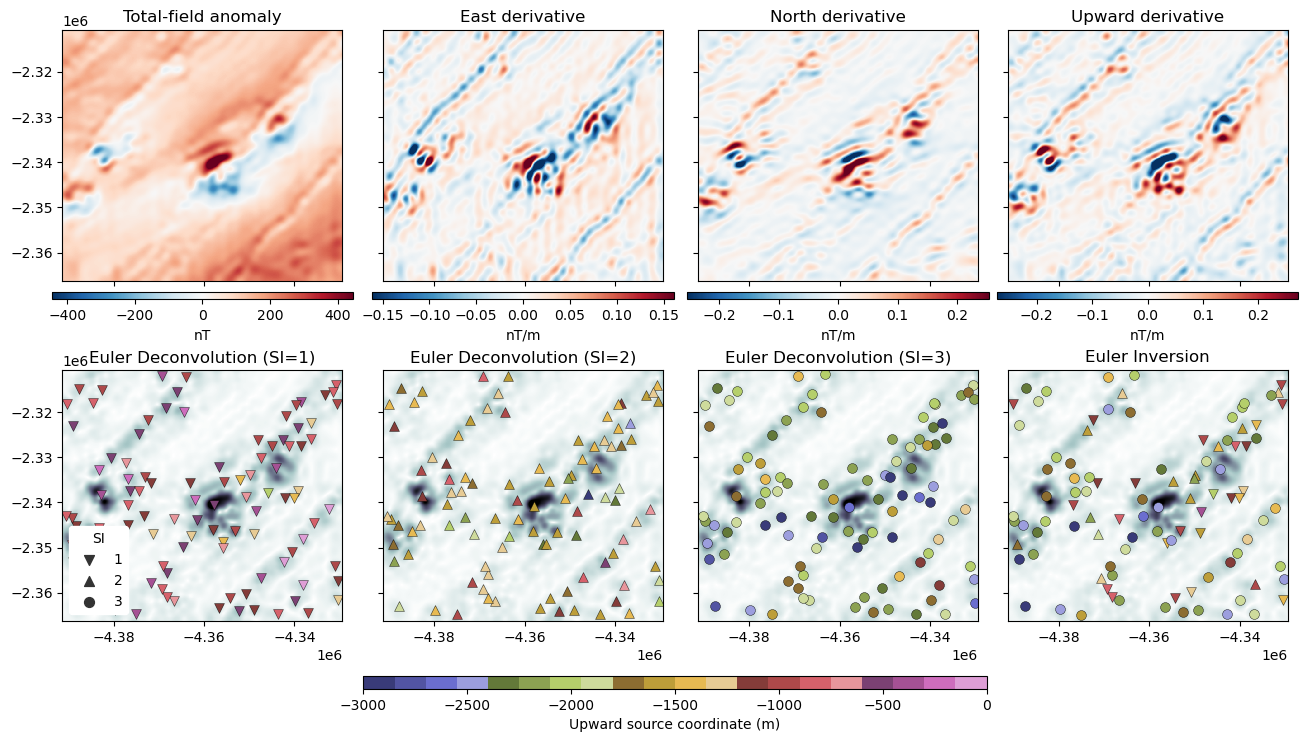

In [28]:
fig, axes = plt.subplots(
    2, 4, figsize=(13, 7.3), layout="constrained", sharey=True, sharex=True
)

subplot_labels = [f"{i})" for i in "abcdefgh"]
units = {
    "tfa_nt": "nT",
    "deriv_east": "nT/m",
    "deriv_north": "nT/m",
    "deriv_up": "nT/m",
}
data_names = {
    "tfa_nt": "Total-field anomaly",
    "deriv_east": "East derivative",
    "deriv_north": "North derivative",
    "deriv_up": "Upward derivative",
}
markers = ["v", "^", "o"]
vmin, vmax = -3000, 0
size = 50


for field, ax in zip(["tfa_nt", "deriv_east", "deriv_north", "deriv_up"], axes[0, :]):
    ax.set_aspect("equal")
    scale = np.percentile(grid[field].values, 99.8)
    tmp = grid[field].plot.pcolormesh(
        ax=ax,
        add_colorbar=False,
        add_labels=False,
        vmax=scale,
        vmin=-scale,
        cmap="RdBu_r",
    )
    fig.colorbar(
        tmp, ax=ax, orientation="horizontal", aspect=40, pad=0.02, label=units[field]
    )
    ax.set_title(data_names[field])
ax = axes[0, 0]

scale = np.percentile(grid.tga.values, 99.9)
for ax in axes[1, :]:
    ax.set_aspect("equal")
    grid.tga.plot.pcolormesh(
        ax=ax, add_colorbar=False, add_labels=False, vmax=scale, vmin=0, cmap="bone_r"
    )

# Euler deconvolution
for si, marker, ax in zip([1, 2, 3], markers, axes[1, :-1]):
    ax.set_title(f"Euler Deconvolution (SI={si})")
    for k, window in enumerate(windows):
        ax.scatter(
            *deconvolutions[si][k].location_[:2],
            c=deconvolutions[si][k].location_[2],
            s=size,
            marker=marker,
            vmin=vmin,
            vmax=vmax,
            edgecolors="black",
            linewidths=0.3,
            cmap="tab20b",
        )
# Euler inversion
labels = {}
ax = axes[1, -1]
ax.set_title("Euler Inversion")

for si, marker in zip(ei.keys(), markers):
    for k, solution in enumerate(ei[si]):

        tmp = ax.scatter(
            *solution.location_[:2],
            c=solution.location_[2],
            s=size,
            marker=marker,
            vmin=vmin,
            vmax=vmax,
            edgecolors="black",
            linewidths=0.3,
            cmap="tab20b",
        )
    labels[si] = ax.scatter([], [], c="#333333", s=size, marker=marker)

axes[1, 0].legend(
    [labels[si] for si in sorted(labels)],
    sorted(labels),
    loc="lower left",
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    title="SI",
)
fig.colorbar(
    tmp,
    ax=axes[1, :],
    aspect=50,
    pad=0.05,
    shrink=0.5,
    orientation="horizontal",
    label="Upward source coordinate (m)",
)

# for ax, label in zip(axes.ravel(), subplot_labels):
#     ax.text(-0.05, 1.04, label, transform=ax.transAxes)
# for ax in axes[1, :]:
#     ax.set_xticks(np.arange(0, 61e3, 20e3))
# for ax in axes[:, 0]:
#     ax.set_yticks(np.arange(0, 61e3, 20e3))
# for ax in axes[:, 0]:
#     ax.set_ylabel("Northing (m)")
# for ax in axes[1, :]:
#     ax.set_xlabel("Easting (m)")

# Test with line data

In [29]:
data

longitude   latitude  total_field_anomaly_nt  height_ell_m line_type  \
0     -42.590424 -22.499878                  115.41        264.26      LINE   
1     -42.590485 -22.498978                  121.35        265.48      LINE   
2     -42.590530 -22.498077                  128.29        263.96      LINE   
3     -42.590591 -22.497177                  133.24        258.47      LINE   
4     -42.590652 -22.496277                  136.18        252.07      LINE   
...          ...        ...                     ...           ...       ...   
37713 -42.023544 -22.073761                    6.20        269.75       TIE   
37714 -42.024536 -22.073776                   16.26        263.96       TIE   
37715 -42.025513 -22.073776                   30.33        255.73       TIE   
37716 -42.026505 -22.073776                   46.39        247.19       TIE   
37717 -42.027496 -22.073776                   61.45        240.49       TIE   

       line_number     easting_m    northing_m  tfa_predict   residual  \
0             2902 -4.390282e+06 -2.366202e+06   119.600556  -4.190556   
1             2902 -4.390289e+06 -2.366102e+06   120.622970   0.727030   
2             2902 -4.390293e+06 -2.366002e+06   121.631920   6.658080   
3             2902 -4.390300e+06 -2.365902e+06   122.645590  10.594410   
4             2902 -4.390306e+06 -2.365802e+06   123.593479  12.586521   
...            ...           ...           ...          ...        ...   
37713         9600 -4.331848e+06 -2.319003e+06    16.051288  -9.851288   
37714         9600 -4.331950e+06 -2.319005e+06    19.074118  -2.814118   
37715         9600 -4.332051e+06 -2.319005e+06    21.878361   8.451639   
37716         9600 -4.332153e+06 -2.319005e+06    24.482402  21.907598   
37717         9600 -4.332255e+06 -2.319005e+06    26.801160  34.648840   

       easting_derivative  northing_derivative  upward_derivative  
0                0.000995             0.010938          -0.021479  
1                0.001404             0.010212          -0.022145  
2                0.001836             0.009432          -0.022726  
3                0.002319             0.008595          -0.023244  
4                0.002849             0.007704          -0.023627  
...                   ...                  ...                ...  
37713           -0.031788             0.033293           0.015104  
37714           -0.029707             0.030139           0.010283  
37715           -0.027230             0.026843           0.006005  
37716           -0.024333             0.023353           0.002333  
37717           -0.021156             0.019871          -0.000459  

[37718 rows x 13 columns]

# Euler deconvolution

In [30]:
%%time
deconvolutions = {1: [], 2: [], 3: []}

# Exemplo de dados gerados para cada chave
for window in windows:
    # Slicing os dados da janela
    data_slice = data[(data['easting_m'] >= window[0]) & (data['easting_m'] <= window[1]) &
                      (data['northing_m'] >= window[2]) & (data['northing_m'] <= window[3])]

    euler_data = [data_slice.total_field_anomaly_nt.values, 
                  data_slice.easting_derivative.values, 
                  data_slice.northing_derivative.values, 
                  data_slice.upward_derivative.values]
    
    coordinates_slice = [data_slice['easting_m'], data_slice['northing_m'], data_slice['height_ell_m']]
    
    for si in deconvolutions.keys():
        # Cria uma nova instância de EulerDeconvolution e ajusta os dados
        deconvolution_result = euler.EulerDeconvolution(structural_index=si).fit(coordinates_slice, data=euler_data)
        # Armazena o resultado na lista correspondente
        deconvolutions[si].append(deconvolution_result)

CPU times: user 134 ms, sys: 65 μs, total: 135 ms
Wall time: 134 ms


# Euler inversion

In [31]:
%%time
ei = {1: [], 2: [], 3: []}
for window in windows:
    # Slicing os dados da janela
    data_slice = data[(data['easting_m']  >= window[0]) & (data['easting_m']  <= window[1]) &
                      (data['northing_m'] >= window[2]) & (data['northing_m'] <= window[3])]

    inversion_data = [data_slice.total_field_anomaly_nt.values, 
                      data_slice.easting_derivative.values, 
                      data_slice.northing_derivative.values, 
                      data_slice.upward_derivative.values]
    
    coordinates_slice = [data_slice['easting_m'].values, data_slice['northing_m'].values, data_slice['height_ell_m'].values]

    # choose the best si
    tolerance = np.inf
    for si in deconvolutions.keys():
        ei_result =  euler.EulerInversion(si).fit(coordinates_slice, data=inversion_data)

        RMS = ei_result.data_misfit_[-1]

        if RMS <= tolerance:
            chosen_si = si   # updates the chosen si
            tolerance = RMS   # updates the r2 for a bigger one
    
    ei[chosen_si].append(euler.EulerInversion(chosen_si).fit(coordinates_slice, data=inversion_data))

CPU times: user 1.55 s, sys: 41 μs, total: 1.55 s
Wall time: 1.54 s


In [32]:
%%time
ei = {1: [], 2: [], 3: []}
for window in windows:
    # Slicing os dados da janela
    data_slice = data[(data['easting_m']  >= window[0]) & (data['easting_m']  <= window[1]) &
                      (data['northing_m'] >= window[2]) & (data['northing_m'] <= window[3])]

    inversion_data = [data_slice.total_field_anomaly_nt.values, 
                      data_slice.easting_derivative.values, 
                      data_slice.northing_derivative.values, 
                      data_slice.upward_derivative.values]
    
    coordinates_slice = [data_slice['easting_m'].values, data_slice['northing_m'].values, data_slice['height_ell_m'].values]

    # choose the best si
    tolerance = -np.inf
    for si in deconvolutions.keys():
        ei_result =  euler.EulerInversion(si).fit(coordinates_slice, data=inversion_data)

        weights = np.array([1,0.1,0.1,0.05])
        variables = ['total_field_anomaly_nt', 'easting_derivative', 'northing_derivative', 'upward_derivative']
        pred_variables = (ei_result.predicted_field_.ravel(), ei_result.predicted_deriv_east_.ravel(),
                          ei_result.predicted_deriv_north_.ravel(), ei_result.predicted_deriv_up_.ravel())
        r2=0
        for weight, variable, d_predicted in zip(weights, variables, pred_variables):
            d = data_slice[variable].values.ravel()
            residuals = d - d_predicted
            residuals_sum_sq = np.sum(residuals**2)
            
            r2 += (1 - residuals_sum_sq / np.linalg.norm(d - d.mean()) ** 2) * weight

        r2 /= weights.sum()
        if r2 >= tolerance:
            chosen_si = si   # updates the chosen si
            tolerance = r2   # updates the r2 for a bigger one
            
    ei[chosen_si].append(euler.EulerInversion(chosen_si).fit(coordinates_slice, data=inversion_data))

CPU times: user 1.58 s, sys: 0 ns, total: 1.58 s
Wall time: 1.58 s


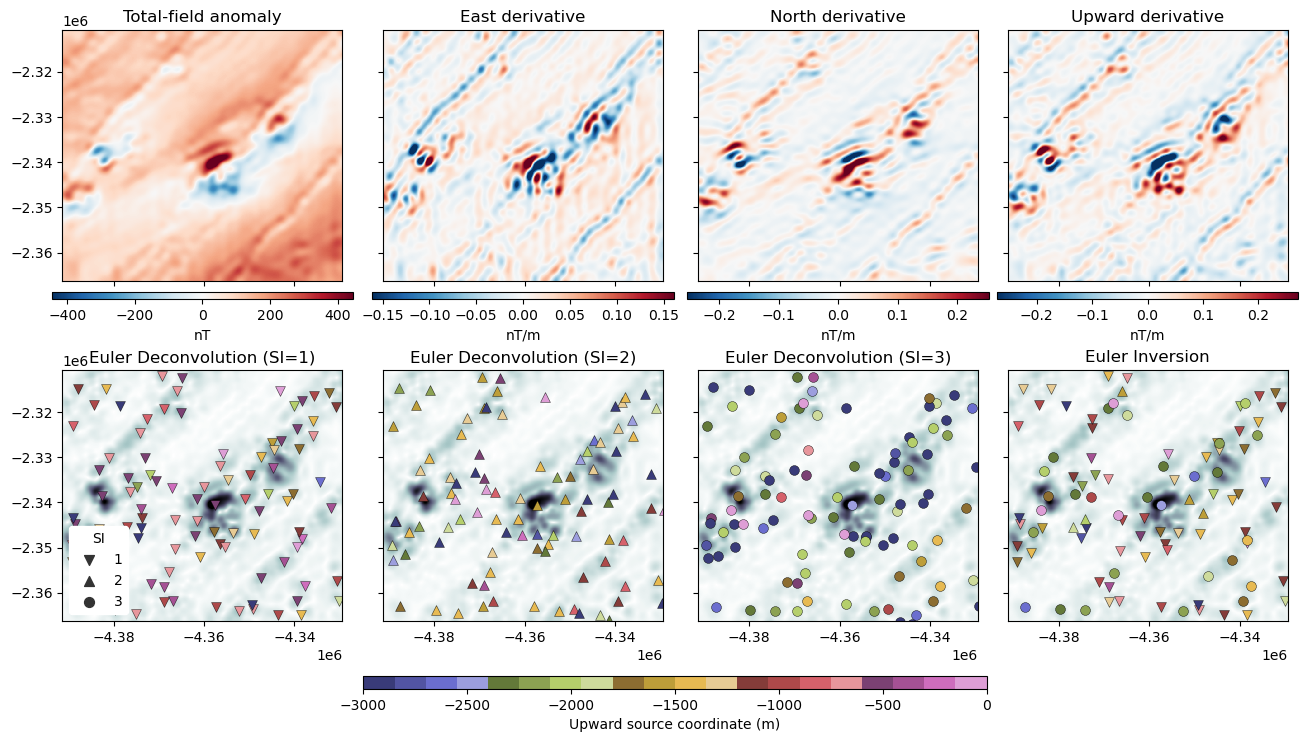

In [33]:
fig, axes = plt.subplots(
    2, 4, figsize=(13, 7.3), layout="constrained", sharey=True, sharex=True
)

subplot_labels = [f"{i})" for i in "abcdefgh"]
units = {
    "tfa_nt": "nT",
    "deriv_east": "nT/m",
    "deriv_north": "nT/m",
    "deriv_up": "nT/m",
}
data_names = {
    "tfa_nt": "Total-field anomaly",
    "deriv_east": "East derivative",
    "deriv_north": "North derivative",
    "deriv_up": "Upward derivative",
}
markers = ["v", "^", "o"]
vmin, vmax = -3000, 0
size = 50


for field, ax in zip(["tfa_nt", "deriv_east", "deriv_north", "deriv_up"], axes[0, :]):
    ax.set_aspect("equal")
    scale = np.percentile(grid[field].values, 99.8)
    tmp = grid[field].plot.pcolormesh(
        ax=ax,
        add_colorbar=False,
        add_labels=False,
        vmax=scale,
        vmin=-scale,
        cmap="RdBu_r",
    )
    fig.colorbar(
        tmp, ax=ax, orientation="horizontal", aspect=40, pad=0.02, label=units[field]
    )
    ax.set_title(data_names[field])
ax = axes[0, 0]

scale = np.percentile(grid.tga.values, 99.9)
for ax in axes[1, :]:
    ax.set_aspect("equal")
    grid.tga.plot.pcolormesh(
        ax=ax, add_colorbar=False, add_labels=False, vmax=scale, vmin=0, cmap="bone_r"
    )

# Euler deconvolution
for si, marker, ax in zip([1, 2, 3], markers, axes[1, :-1]):
    ax.set_title(f"Euler Deconvolution (SI={si})")
    for k, window in enumerate(windows):
        ax.scatter(
            *deconvolutions[si][k].location_[:2],
            c=deconvolutions[si][k].location_[2],
            s=size,
            marker=marker,
            vmin=vmin,
            vmax=vmax,
            edgecolors="black",
            linewidths=0.3,
            cmap="tab20b",
        )
# Euler inversion
labels = {}
ax = axes[1, -1]
ax.set_title("Euler Inversion")

for si, marker in zip(ei.keys(), markers):
    for k, solution in enumerate(ei[si]):

        tmp = ax.scatter(
            *solution.location_[:2],
            c=solution.location_[2],
            s=size,
            marker=marker,
            vmin=vmin,
            vmax=vmax,
            edgecolors="black",
            linewidths=0.3,
            cmap="tab20b",
        )
    labels[si] = ax.scatter([], [], c="#333333", s=size, marker=marker)

axes[1, 0].legend(
    [labels[si] for si in sorted(labels)],
    sorted(labels),
    loc="lower left",
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    title="SI",
)
fig.colorbar(
    tmp,
    ax=axes[1, :],
    aspect=50,
    pad=0.05,
    shrink=0.5,
    orientation="horizontal",
    label="Upward source coordinate (m)",
)

# for ax, label in zip(axes.ravel(), subplot_labels):
#     ax.text(-0.05, 1.04, label, transform=ax.transAxes)
# for ax in axes[1, :]:
#     ax.set_xticks(np.arange(0, 61e3, 20e3))
# for ax in axes[:, 0]:
#     ax.set_yticks(np.arange(0, 61e3, 20e3))
# for ax in axes[:, 0]:
#     ax.set_ylabel("Northing (m)")
# for ax in axes[1, :]:
#     ax.set_xlabel("Easting (m)")

# Growing windows

(206,)


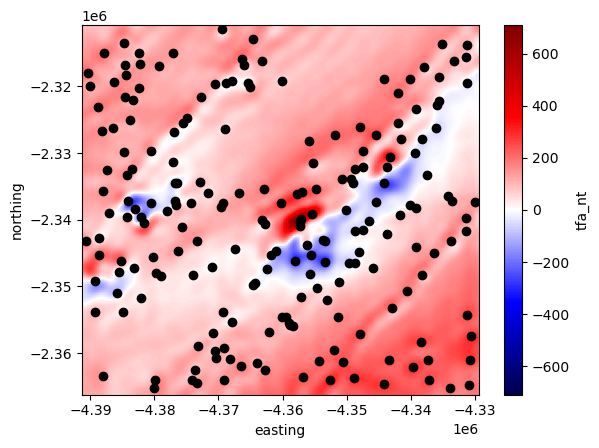

In [52]:
# Show windows centers
center_easting = []
center_northing = []
ax = plt.subplot(111)
grid.tfa_nt.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    center_easting.append( (window[0] + window[1]) / 2)
    center_northing.append((window[2] + window[3]) / 2)

ax.scatter(center_easting, center_northing, c='k')
print(np.shape(center_easting))

# Euler inversion

In [35]:
# %%time
# ei = {1: [], 2: [], 3: []}

# # Create the range of window sizes
# window_sizes = np.arange(1000, 10000, 500)

# # Condition to avoid windows extrapolating the data boundaries
# easting_min, easting_max = grid.easting.min(), grid.easting.max()
# northing_min, northing_max = grid.northing.min(), grid.northing.max()

# for window in windows:
#     for window_size in window_sizes:
#         # Calculate the center of the window
#         center_easting = (window[0] + window[1]) / 2
#         center_northing = (window[2] + window[3]) / 2
        
#         # Get the size of the window
#         easting_start = center_easting - window_size / 2
#         easting_end = center_easting + window_size / 2
#         northing_start = center_northing - window_size / 2
#         northing_end = center_northing + window_size / 2
        
#         # Verify if the window is within the data boundaries
#         if (easting_start < easting_min or easting_end > easting_max or
#             northing_start < northing_min or northing_end > northing_max):
#             continue
        
#         # Get the sliced data
#         easting_range = slice(easting_start, easting_end)
#         northing_range = slice(northing_start, northing_end)
        
#         data_slice = grid.sel(easting=easting_range, northing=northing_range)

#           # choose the best si
#         tolerance = np.inf
#         for si in deconvolutions.keys():
#             ei_result =  euler.EulerInversion(si).fit_grid(data_slice, 
#                                                            data_names=(['tfa_nt', 'deriv_east', 'deriv_north', 'deriv_up']),
#                                                            coordinate_names=(['easting', 'northing', 'upward']))
    
#             RMS = ei_result.data_misfit_[-1]
    
#             if RMS <= tolerance:
#                 chosen_si = si   # updates the chosen si
#                 chosen_window = [easting_start, easting_end, northing_start, northing_end]
#                 tolerance = RMS   # updates the r2 for a bigger one
    
#     chosen_easting_range = slice(chosen_window[0], chosen_window[1])
#     chosen_northing_range = slice(chosen_window[2], chosen_window[3])
#     chosen_data_slice =  grid.sel(easting=chosen_easting_range, northing=chosen_northing_range)     
#     ei[chosen_si].append(euler.EulerInversion(chosen_si).fit_grid(chosen_data_slice, 
#                                                                   data_names=(['tfa_nt', 'deriv_east', 'deriv_north', 'deriv_up']),
#                                                                   coordinate_names=(['easting', 'northing', 'upward'])))

In [36]:
%%time
ei = {1: [], 2: [], 3: []}

# Create the range of window sizes
window_sizes = np.arange(2000, 10000, 1000)

# Condition to avoid windows extrapolating the data boundaries
easting_min, easting_max = grid.easting.min(), grid.easting.max()
northing_min, northing_max = grid.northing.min(), grid.northing.max()

for window in windows:
    for window_size in window_sizes:
        # Calculate the center of the window
        center_easting = (window[0] + window[1]) / 2
        center_northing = (window[2] + window[3]) / 2
        
        # Get the size of the window
        easting_start = center_easting - window_size / 2
        easting_end = center_easting + window_size / 2
        northing_start = center_northing - window_size / 2
        northing_end = center_northing + window_size / 2
        
        # Verify if the window is within the data boundaries
        if (easting_start < easting_min or easting_end > easting_max or
            northing_start < northing_min or northing_end > northing_max):
            continue
        
        # Get the sliced data
        easting_range = slice(easting_start, easting_end)
        northing_range = slice(northing_start, northing_end)
        
        data_slice = grid.sel(easting=easting_range, northing=northing_range)

        tolerance = -np.inf
        for si in deconvolutions.keys():
            ei_result =  euler.EulerInversion(si).fit_grid(data_slice, 
                                                           data_names=(['tfa_nt', 'deriv_east', 'deriv_north', 'deriv_up']),
                                                           coordinate_names=(['easting', 'northing', 'upward']))
    
            weights = np.array([1,0.1,0.1,0.05])
            variables = ['tfa_nt', 'deriv_east', 'deriv_north', 'deriv_up']
            pred_variables = (ei_result.predicted_field_.ravel(), ei_result.predicted_deriv_east_.ravel(),
                              ei_result.predicted_deriv_north_.ravel(), ei_result.predicted_deriv_up_.ravel())
            r2=0
            for weight, variable, d_predicted in zip(weights, variables, pred_variables):
                d = data_slice[variable].values.ravel()
                residuals = d - d_predicted
                residuals_sum_sq = np.sum(residuals**2)
                
                r2 += (1 - residuals_sum_sq / np.linalg.norm(d - d.mean()) ** 2) * weight
    
            r2 /= weights.sum()
            if r2 >= tolerance:
                chosen_si = si   # updates the chosen si
                tolerance = r2   # updates the r2 for a bigger one
                chosen_window = [easting_start, easting_end, northing_start, northing_end]
                
    chosen_easting_range = slice(chosen_window[0], chosen_window[1])
    chosen_northing_range = slice(chosen_window[2], chosen_window[3])
    chosen_data_slice =  grid.sel(easting=chosen_easting_range, northing=chosen_northing_range)     
    ei[chosen_si].append(euler.EulerInversion(chosen_si).fit_grid(chosen_data_slice, 
                                                                  data_names=(['tfa_nt', 'deriv_east', 'deriv_north', 'deriv_up']),
                                                                  coordinate_names=(['easting', 'northing', 'upward'])))


CPU times: user 8min 44s, sys: 131 ms, total: 8min 44s
Wall time: 41.3 s


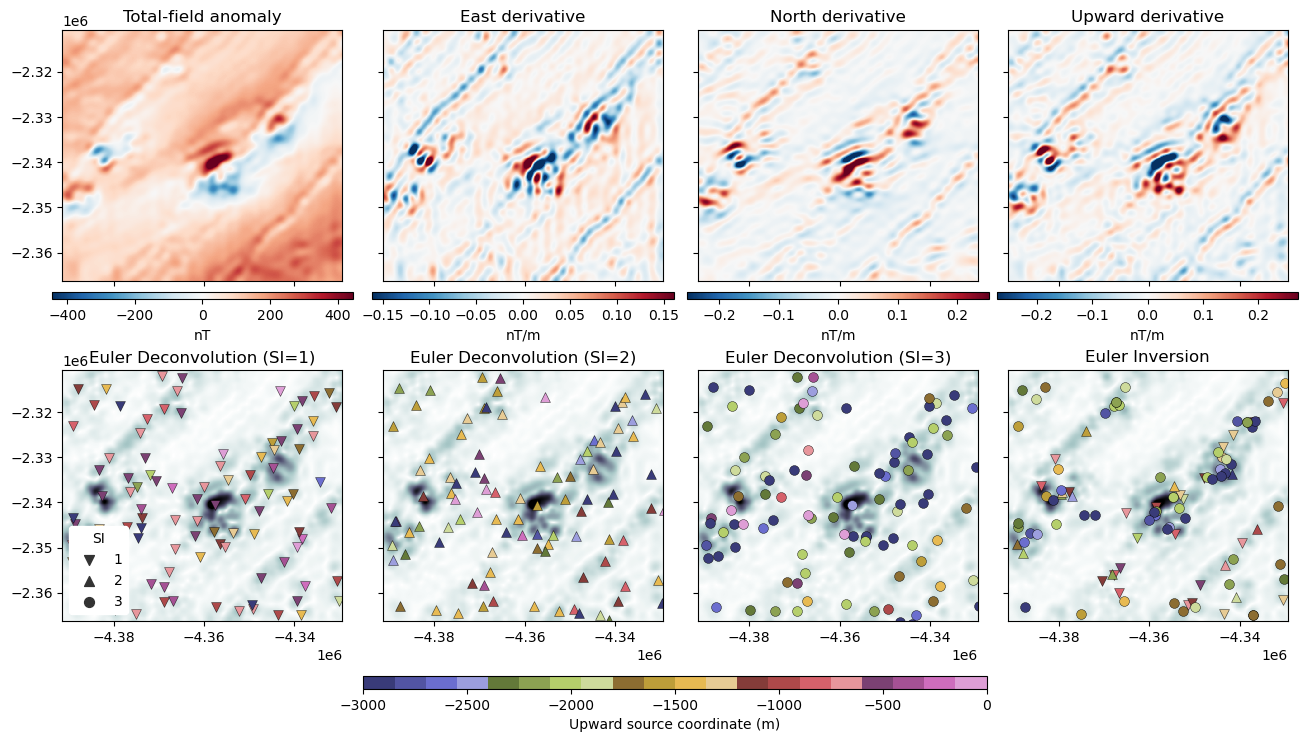

In [37]:
fig, axes = plt.subplots(
    2, 4, figsize=(13, 7.3), layout="constrained", sharey=True, sharex=True
)

subplot_labels = [f"{i})" for i in "abcdefgh"]
units = {
    "tfa_nt": "nT",
    "deriv_east": "nT/m",
    "deriv_north": "nT/m",
    "deriv_up": "nT/m",
}
data_names = {
    "tfa_nt": "Total-field anomaly",
    "deriv_east": "East derivative",
    "deriv_north": "North derivative",
    "deriv_up": "Upward derivative",
}
markers = ["v", "^", "o"]
vmin, vmax = -3000, 0
size = 50


for field, ax in zip(["tfa_nt", "deriv_east", "deriv_north", "deriv_up"], axes[0, :]):
    ax.set_aspect("equal")
    scale = np.percentile(grid[field].values, 99.8)
    tmp = grid[field].plot.pcolormesh(
        ax=ax,
        add_colorbar=False,
        add_labels=False,
        vmax=scale,
        vmin=-scale,
        cmap="RdBu_r",
    )
    fig.colorbar(
        tmp, ax=ax, orientation="horizontal", aspect=40, pad=0.02, label=units[field]
    )
    ax.set_title(data_names[field])
ax = axes[0, 0]

scale = np.percentile(grid.tga.values, 99.9)
for ax in axes[1, :]:
    ax.set_aspect("equal")
    grid.tga.plot.pcolormesh(
        ax=ax, add_colorbar=False, add_labels=False, vmax=scale, vmin=0, cmap="bone_r"
    )

# Euler deconvolution
for si, marker, ax in zip([1, 2, 3], markers, axes[1, :-1]):
    ax.set_title(f"Euler Deconvolution (SI={si})")
    for k, window in enumerate(windows):
        ax.scatter(
            *deconvolutions[si][k].location_[:2],
            c=deconvolutions[si][k].location_[2],
            s=size,
            marker=marker,
            vmin=vmin,
            vmax=vmax,
            edgecolors="black",
            linewidths=0.3,
            cmap="tab20b",
        )
# Euler inversion
labels = {}
ax = axes[1, -1]
ax.set_title("Euler Inversion")

for si, marker in zip(ei.keys(), markers):
    for k, solution in enumerate(ei[si]):

        tmp = ax.scatter(
            *solution.location_[:2],
            c=solution.location_[2],
            s=size,
            marker=marker,
            vmin=vmin,
            vmax=vmax,
            edgecolors="black",
            linewidths=0.3,
            cmap="tab20b",
        )
    labels[si] = ax.scatter([], [], c="#333333", s=size, marker=marker)

axes[1, 0].legend(
    [labels[si] for si in sorted(labels)],
    sorted(labels),
    loc="lower left",
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    title="SI",
)
fig.colorbar(
    tmp,
    ax=axes[1, :],
    aspect=50,
    pad=0.05,
    shrink=0.5,
    orientation="horizontal",
    label="Upward source coordinate (m)",
)

# for ax, label in zip(axes.ravel(), subplot_labels):
#     ax.text(-0.05, 1.04, label, transform=ax.transAxes)
# for ax in axes[1, :]:
#     ax.set_xticks(np.arange(0, 61e3, 20e3))
# for ax in axes[:, 0]:
#     ax.set_yticks(np.arange(0, 61e3, 20e3))
# for ax in axes[:, 0]:
#     ax.set_ylabel("Northing (m)")
# for ax in axes[1, :]:
#     ax.set_xlabel("Easting (m)")

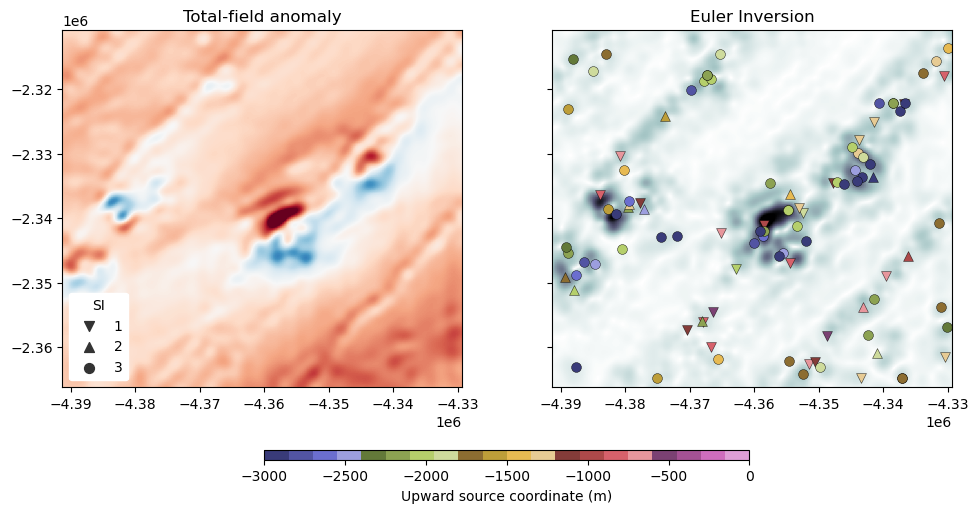

In [38]:
fig, axes = plt.subplots(
    1, 2, figsize=(10, 5), layout="constrained", sharey=True
)

subplot_labels = [f"{i})" for i in "ab"]
units = {
    "tfa_nt": "nT",
    "deriv_east": "nT/m",
    "deriv_north": "nT/m",
    "deriv_up": "nT/m",
}
data_names = {
    "tfa_nt": "Total-field anomaly",
    "deriv_east": "East derivative",
    "deriv_north": "North derivative",
    "deriv_up": "Upward derivative",
}
markers = ["v", "^", "o"]
vmin, vmax = -3000, 0
size = 50


ax = axes[0]
ax.set_aspect("equal")
scale = np.percentile(grid.tfa_nt.values, 99.8)
tmp = grid.tfa_nt.plot.pcolormesh(
    ax=ax,
    add_colorbar=False,
    add_labels=False,
    vmax=scale,
    vmin=-scale,
    cmap="RdBu_r",
)

ax.set_title(data_names['tfa_nt'])



# Euler inversion
labels = {}
ax = axes[1]
ax.set_title("Euler Inversion")


ax.set_aspect("equal")
scale = np.percentile(grid.tga.values, 99.9)
tmp = grid.tga.plot.pcolormesh(
    ax=ax,
    add_colorbar=False,
    add_labels=False,
    vmax=scale,
    vmin=0,
    cmap="bone_r",
)

for si, marker in zip(ei.keys(), markers):
    for k, solution in enumerate(ei[si]):

        tmp = ax.scatter(
            *solution.location_[:2],
            c=solution.location_[2],
            s=size,
            marker=marker,
            vmin=vmin,
            vmax=vmax,
            edgecolors="black",
            linewidths=0.3,
            cmap="tab20b",
        )
    labels[si] = ax.scatter([], [], c="#333333", s=size, marker=marker)

axes[0].legend(
    [labels[si] for si in sorted(labels)],
    sorted(labels),
    loc="lower left",
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    title="SI",
)
fig.colorbar(
    tmp,
    ax=axes[:],
    aspect=50,
    pad=0.05,
    shrink=0.5,
    orientation="horizontal",
    label="Upward source coordinate (m)",
)

# for ax, label in zip(axes.ravel(), subplot_labels):
#     ax.text(-0.05, 1.04, label, transform=ax.transAxes)
# for ax in axes[1, :]:
#     ax.set_xticks(np.arange(0, 61e3, 20e3))
# for ax in axes[:, 0]:
#     ax.set_yticks(np.arange(0, 61e3, 20e3))
# for ax in axes[:, 0]:
#     ax.set_ylabel("Northing (m)")
# for ax in axes[1, :]:
#     ax.set_xlabel("Easting (m)")

# Block averaging

In [53]:
# Show windows centers
center_easting = []
center_northing = []

for window in windows:
    center_easting.append( (window[0] + window[1]) / 2)
    center_northing.append((window[2] + window[3]) / 2)


In [54]:
region = vd.get_region(([center_easting, center_northing]))
block_spacing = 3e3 # meters
reducer = vd.BlockReduce(
    reduction=np.median,
    spacing=block_spacing,
    region=(vd.pad_region(region, pad=block_spacing*0.5)),
    drop_coords=False
)

blocked_center, _ = reducer.filter([np.asarray(center_easting), np.asarray(center_northing)], data=np.zeros(np.shape(center_easting)))
print(np.shape(blocked_center))

(2, 162)


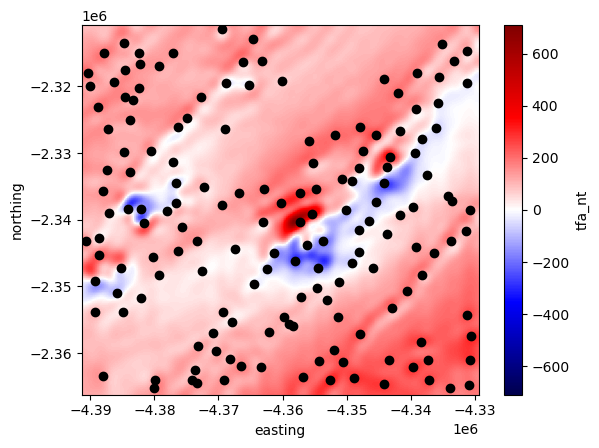

In [55]:
ax = plt.subplot(111)
grid.tfa_nt.plot.pcolormesh(ax=ax, cmap="seismic")
ax.scatter(blocked_center[0], blocked_center[1], c='k')

In [45]:
%%time
ei = {1: [], 2: [], 3: []}

# Create the range of window sizes
window_sizes = np.arange(2000, 10000, 1000)

# Condition to avoid windows extrapolating the data boundaries
easting_min, easting_max = grid.easting.min(), grid.easting.max()
northing_min, northing_max = grid.northing.min(), grid.northing.max()

for i in range(np.shape(blocked_center)[1]):
    for window_size in window_sizes:
        # Calculate the center of the window
        center_easting = blocked_center[0][i]
        center_northing = blocked_center[1][i]
        
        # Get the size of the window
        easting_start = center_easting - window_size / 2
        easting_end = center_easting + window_size / 2
        northing_start = center_northing - window_size / 2
        northing_end = center_northing + window_size / 2
        
        # Verify if the window is within the data boundaries
        if (easting_start < easting_min or easting_end > easting_max or
            northing_start < northing_min or northing_end > northing_max):
            continue
        
        # Get the sliced data
        easting_range = slice(easting_start, easting_end)
        northing_range = slice(northing_start, northing_end)
        
        data_slice = grid.sel(easting=easting_range, northing=northing_range)

        tolerance = -np.inf
        for si in deconvolutions.keys():
            ei_result =  euler.EulerInversion(si).fit_grid(data_slice, 
                                                           data_names=(['tfa_nt', 'deriv_east', 'deriv_north', 'deriv_up']),
                                                           coordinate_names=(['easting', 'northing', 'upward']))
    
            weights = np.array([1,0.1,0.1,0.05])
            variables = ['tfa_nt', 'deriv_east', 'deriv_north', 'deriv_up']
            pred_variables = (ei_result.predicted_field_.ravel(), ei_result.predicted_deriv_east_.ravel(),
                              ei_result.predicted_deriv_north_.ravel(), ei_result.predicted_deriv_up_.ravel())
            r2=0
            for weight, variable, d_predicted in zip(weights, variables, pred_variables):
                d = data_slice[variable].values.ravel()
                residuals = d - d_predicted
                residuals_sum_sq = np.sum(residuals**2)
                
                r2 += (1 - residuals_sum_sq / np.linalg.norm(d - d.mean()) ** 2) * weight
    
            r2 /= weights.sum()
            if r2 >= tolerance:
                chosen_si = si   # updates the chosen si
                tolerance = r2   # updates the r2 for a bigger one
                chosen_window = [easting_start, easting_end, northing_start, northing_end]
                

    # if tolerance >= 0.9:
    chosen_easting_range = slice(chosen_window[0], chosen_window[1])
    chosen_northing_range = slice(chosen_window[2], chosen_window[3])
    chosen_data_slice =  grid.sel(easting=chosen_easting_range, northing=chosen_northing_range)     
    ei[chosen_si].append(euler.EulerInversion(chosen_si).fit_grid(chosen_data_slice, 
                                                                  data_names=(['tfa_nt', 'deriv_east', 'deriv_north', 'deriv_up']),
                                                                  coordinate_names=(['easting', 'northing', 'upward'])))


CPU times: user 6min 40s, sys: 81.2 ms, total: 6min 41s
Wall time: 31.7 s


In [46]:
# fig, axes = plt.subplots(
#     2, 4, figsize=(13, 7.3), layout="constrained", sharey=True, sharex=True
# )

# subplot_labels = [f"{i})" for i in "abcdefgh"]
# units = {
#     "tfa_nt": "nT",
#     "deriv_east": "nT/m",
#     "deriv_north": "nT/m",
#     "deriv_up": "nT/m",
# }
# data_names = {
#     "tfa_nt": "Total-field anomaly",
#     "deriv_east": "East derivative",
#     "deriv_north": "North derivative",
#     "deriv_up": "Upward derivative",
# }
# markers = ["v", "^", "o"]
# vmin, vmax = -3000, 0
# size = 50


# for field, ax in zip(["tfa_nt", "deriv_east", "deriv_north", "deriv_up"], axes[0, :]):
#     ax.set_aspect("equal")
#     scale = np.percentile(grid[field].values, 99.8)
#     tmp = grid[field].plot.pcolormesh(
#         ax=ax,
#         add_colorbar=False,
#         add_labels=False,
#         vmax=scale,
#         vmin=-scale,
#         cmap="RdBu_r",
#     )
#     fig.colorbar(
#         tmp, ax=ax, orientation="horizontal", aspect=40, pad=0.02, label=units[field]
#     )
#     ax.set_title(data_names[field])
# ax = axes[0, 0]

# scale = np.percentile(grid.tga.values, 99.9)
# for ax in axes[1, :]:
#     ax.set_aspect("equal")
#     grid.tga.plot.pcolormesh(
#         ax=ax, add_colorbar=False, add_labels=False, vmax=scale, vmin=0, cmap="bone_r"
#     )

# # Euler deconvolution
# for si, marker, ax in zip([1, 2, 3], markers, axes[1, :-1]):
#     ax.set_title(f"Euler Deconvolution (SI={si})")
#     for k, window in enumerate(windows):
#         ax.scatter(
#             *deconvolutions[si][k].location_[:2],
#             c=deconvolutions[si][k].location_[2],
#             s=size,
#             marker=marker,
#             vmin=vmin,
#             vmax=vmax,
#             edgecolors="black",
#             linewidths=0.3,
#             cmap="tab20b",
#         )
# # Euler inversion
# labels = {}
# ax = axes[1, -1]
# ax.set_title("Euler Inversion")

# for si, marker in zip(ei.keys(), markers):
#     for k, solution in enumerate(ei[si]):

#         tmp = ax.scatter(
#             *solution.location_[:2],
#             c=solution.location_[2],
#             s=size,
#             marker=marker,
#             vmin=vmin,
#             vmax=vmax,
#             edgecolors="black",
#             linewidths=0.3,
#             cmap="tab20b",
#         )
#     labels[si] = ax.scatter([], [], c="#333333", s=size, marker=marker)

# axes[1, 0].legend(
#     [labels[si] for si in sorted(labels)],
#     sorted(labels),
#     loc="lower left",
#     framealpha=1,
#     facecolor="#ffffff",
#     edgecolor="#ffffff",
#     title="SI",
# )
# fig.colorbar(
#     tmp,
#     ax=axes[1, :],
#     aspect=50,
#     pad=0.05,
#     shrink=0.5,
#     orientation="horizontal",
#     label="Upward source coordinate (m)",
# )

# # for ax, label in zip(axes.ravel(), subplot_labels):
# #     ax.text(-0.05, 1.04, label, transform=ax.transAxes)
# # for ax in axes[1, :]:
# #     ax.set_xticks(np.arange(0, 61e3, 20e3))
# # for ax in axes[:, 0]:
# #     ax.set_yticks(np.arange(0, 61e3, 20e3))
# # for ax in axes[:, 0]:
# #     ax.set_ylabel("Northing (m)")
# # for ax in axes[1, :]:
# #     ax.set_xlabel("Easting (m)")

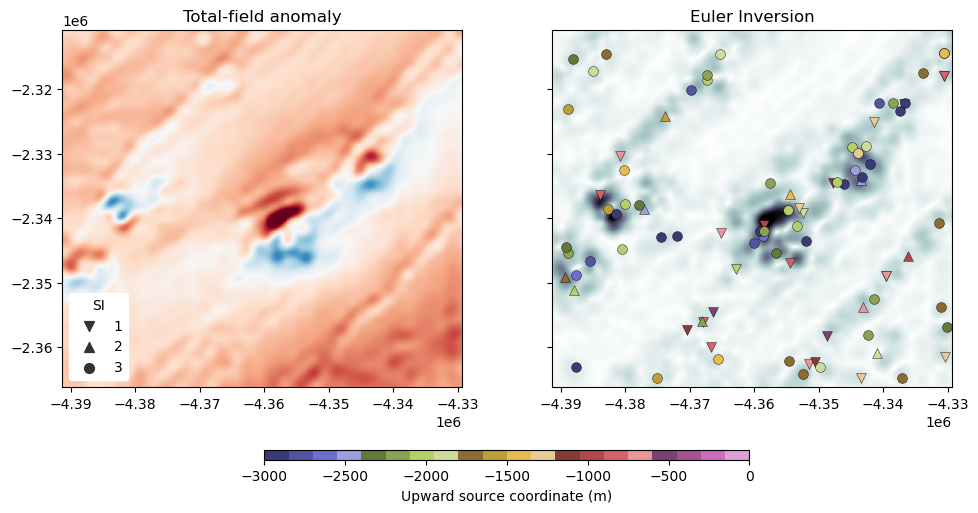

In [47]:
fig, axes = plt.subplots(
    1, 2, figsize=(10, 5), layout="constrained", sharey=True
)

subplot_labels = [f"{i})" for i in "ab"]
units = {
    "tfa_nt": "nT",
    "deriv_east": "nT/m",
    "deriv_north": "nT/m",
    "deriv_up": "nT/m",
}
data_names = {
    "tfa_nt": "Total-field anomaly",
    "deriv_east": "East derivative",
    "deriv_north": "North derivative",
    "deriv_up": "Upward derivative",
}
markers = ["v", "^", "o"]
vmin, vmax = -3000, 0
size = 50


ax = axes[0]
ax.set_aspect("equal")
scale = np.percentile(grid.tfa_nt.values, 99.8)
tmp = grid.tfa_nt.plot.pcolormesh(
    ax=ax,
    add_colorbar=False,
    add_labels=False,
    vmax=scale,
    vmin=-scale,
    cmap="RdBu_r",
)

ax.set_title(data_names['tfa_nt'])



# Euler inversion
labels = {}
ax = axes[1]
ax.set_title("Euler Inversion")


ax.set_aspect("equal")
scale = np.percentile(grid.tga.values, 99.9)
tmp = grid.tga.plot.pcolormesh(
    ax=ax,
    add_colorbar=False,
    add_labels=False,
    vmax=scale,
    vmin=0,
    cmap="bone_r",
)

for si, marker in zip(ei.keys(), markers):
    for k, solution in enumerate(ei[si]):

        tmp = ax.scatter(
            *solution.location_[:2],
            c=solution.location_[2],
            s=size,
            marker=marker,
            vmin=vmin,
            vmax=vmax,
            edgecolors="black",
            linewidths=0.3,
            cmap="tab20b",
        )
    labels[si] = ax.scatter([], [], c="#333333", s=size, marker=marker)

axes[0].legend(
    [labels[si] for si in sorted(labels)],
    sorted(labels),
    loc="lower left",
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    title="SI",
)
fig.colorbar(
    tmp,
    ax=axes[:],
    aspect=50,
    pad=0.05,
    shrink=0.5,
    orientation="horizontal",
    label="Upward source coordinate (m)",
)

# for ax, label in zip(axes.ravel(), subplot_labels):
#     ax.text(-0.05, 1.04, label, transform=ax.transAxes)
# for ax in axes[1, :]:
#     ax.set_xticks(np.arange(0, 61e3, 20e3))
# for ax in axes[:, 0]:
#     ax.set_yticks(np.arange(0, 61e3, 20e3))
# for ax in axes[:, 0]:
#     ax.set_ylabel("Northing (m)")
# for ax in axes[1, :]:
#     ax.set_xlabel("Easting (m)")